# Imports

In [1]:
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Define a Dataset class
This dataset class handles any transformations required to images

In [3]:
class ImageDataset(Dataset):
  def __init__(self, l_file, ab_files, samples = 25000, transform = None):
    self.l_data = np.expand_dims(np.load(l_file), axis = -1)[:samples]

    all_ab_files = [np.load(i) for i in ab_files]
    self.ab_data = np.concatenate(all_ab_files, axis = 0)[:samples].astype('float32') / 255.0
    self.transform = transform

  def __len__(self):
    return len(self.l_data)

  def __getitem__(self, idx):
    gray_tensor = torch.tensor(self.l_data[idx], dtype = torch.float32).permute(2, 1, 0)
    lab_tensor = torch.tensor(self.ab_data[idx], dtype = torch.float32).permute(2, 1, 0)

    if self.transform:
      lab_tensor = self.transform(gray_tensor)
      lab_tensor = self.transform(lab_tensor)

    return (gray_tensor, lab_tensor)

In [4]:
dataset = ImageDataset(l_file = '/kaggle/input/image-colorization/l/gray_scale.npy', ab_files = ['/kaggle/input/image-colorization/ab/ab/ab1.npy', '/kaggle/input/image-colorization/ab/ab/ab2.npy', '/kaggle/input/image-colorization/ab/ab/ab3.npy'], samples = 15000)

# Train and Test split
Splitting the data into 80% for training and 20% for testing

In [6]:
train_n = int(0.8 * len(dataset))
test_n = len(dataset) - train_n
train_set, test_set = torch.utils.data.random_split(dataset, [train_n, test_n])

In [7]:
train_n, test_n

(12000, 3000)

In [8]:
train_loader = DataLoader(train_set, shuffle = True, batch_size = 32)
test_loader = DataLoader(test_set, shuffle = False, batch_size = 32)

# Preprocessing and Visualization

In [9]:
def convert_to_rgb(lab_image, grayscaled_image):
  # Some preprocessing of tensors to numpy
  grayscaled_image = grayscaled_image.permute(2, 1, 0).detach().cpu().numpy()
  lab_image = lab_image.permute(2, 1, 0).detach().cpu().numpy()
  lab_image = lab_image * 255
  
  rgb_image = np.zeros((grayscaled_image.shape[0], grayscaled_image.shape[1], 3))
  
  rgb_image[..., 0] = grayscaled_image[..., 0] # Obtain lightness from grayscaled images
  rgb_image[..., 1:]= lab_image # Obtain everything else from lab images

  rgb_image = rgb_image.astype('uint8')
  rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_LAB2RGB)
  return rgb_image

In [10]:
batch = next(iter(train_loader))

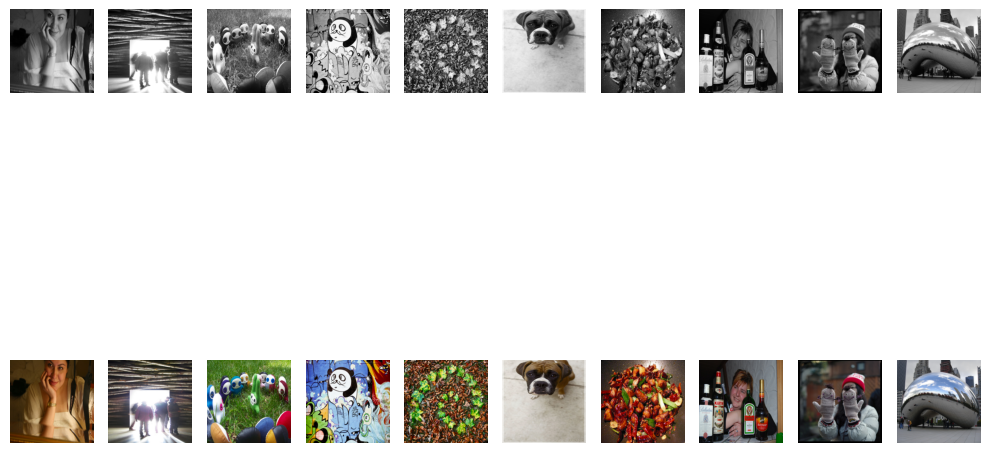

In [11]:
plt.figure(figsize=(10, 10))
for i in range(10):
  plt.subplot(2, 10, i + 1)
  plt.imshow(batch[0][i].permute(2, 1, 0).detach().cpu().numpy(), cmap = 'gray')
  plt.axis('off')

  plt.subplot(2, 10, i + 11)
  plt.imshow(convert_to_rgb(batch[1][i], batch[0][i]))
  plt.axis('off')
plt.tight_layout()
plt.show()

# Define the Convolutional Auto Encoder Architecture

In [12]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
      super().__init__()

      # Use relu as activation function. Apply skip connections (unet architecture), batch normalization

      # Encoder
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1)
      self.conv1_bn = nn.BatchNorm2d(32)

      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
      self.conv2_bn = nn.BatchNorm2d(64)

      self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
      self.conv3_bn = nn.BatchNorm2d(128)

      self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
      self.conv4_bn = nn.BatchNorm2d(256)

      # Bottleneck
      self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=1, padding=3, dilation=2)
      self.conv5_bn = nn.BatchNorm2d(256)

      self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=1, padding=3, dilation=2)
      self.conv6_bn = nn.BatchNorm2d(256)

      # Decoder
      self.t_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
      self.t_conv1_bn = nn.BatchNorm2d(128)

      self.t_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1)
      self.t_conv2_bn = nn.BatchNorm2d(64)

      self.t_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=4, stride=2, padding=1)
      self.t_conv3_bn = nn.BatchNorm2d(32)

      self.t_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=4, stride=2, padding=1)
      self.output = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
      # Encoder
      enc_x_1 = F.relu(self.conv1_bn(self.conv1(x)))
      enc_x_2 = F.relu(self.conv2_bn(self.conv2(enc_x_1)))
      enc_x_3 = F.relu(self.conv3_bn(self.conv3(enc_x_2)))
      enc_x_4 = F.relu(self.conv4_bn(self.conv4(enc_x_3)))

      # Bottleneck
      btln_x_5 = F.relu(self.conv5_bn(self.conv5(enc_x_4)))
      btln_x_6 = F.relu(self.conv6_bn(self.conv6(btln_x_5)))
      
      # Decoder
      dec_x_7 = F.relu(self.t_conv1_bn(self.t_conv1(btln_x_6)))
      dec_x_7 = torch.cat((dec_x_7, enc_x_3), 1) # Skip connections to achieve UNet architecture

      dec_x_8 = F.relu(self.t_conv2_bn(self.t_conv2(dec_x_7)))
      dec_x_8 = torch.cat((dec_x_8, enc_x_2), 1) # Skip connections to achieve UNet architecture

      dec_x_9 = F.relu(self.t_conv3_bn(self.t_conv3(dec_x_8)))
      dec_x_9 = torch.cat((dec_x_9, enc_x_1), 1) # Skip connections to achieve UNet architecture

      dec_x_10 = F.relu(self.t_conv4(dec_x_9))
      dec_x_10 = torch.cat((dec_x_10, x), 1) # Skip connections to achieve UNet architecture

      return self.output(dec_x_10)

# Training the Model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = ConvAutoEncoder().to(device)
epochs = 150

In [14]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
train_loss = []

model.train()

for epoch in range(epochs):
  total_loss = 0
  for gray, lab in train_loader:

    gray = gray.to(device)
    lab = lab.to(device)

    logits = model(gray).to(device)

    loss = loss_fn(logits, lab)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  average_loss = total_loss / len(train_loader)
  train_loss.append(average_loss)
  print(f'Epoch {epoch + 1} Average loss is {average_loss}')

Epoch 1 Average loss is 284.6212930145264
Epoch 2 Average loss is 7.142232743581136
Epoch 3 Average loss is 3.1569330450693767
Epoch 4 Average loss is 1.9854085912704469
Epoch 5 Average loss is 1.417690506140391
Epoch 6 Average loss is 1.0460870122909547
Epoch 7 Average loss is 0.7895513232549032
Epoch 8 Average loss is 0.6140738595326741
Epoch 9 Average loss is 0.4707555209795634
Epoch 10 Average loss is 0.37348869574069976
Epoch 11 Average loss is 0.2938808476924896
Epoch 12 Average loss is 0.23878641812006632
Epoch 13 Average loss is 0.19536444183190663
Epoch 14 Average loss is 0.1660695017973582
Epoch 15 Average loss is 0.1455009556611379
Epoch 16 Average loss is 0.1215266326268514
Epoch 17 Average loss is 0.11030646977821985
Epoch 18 Average loss is 0.0975743744969368
Epoch 19 Average loss is 0.08526088976860047
Epoch 20 Average loss is 0.07922352228562037
Epoch 21 Average loss is 0.07168491897980372
Epoch 22 Average loss is 0.05922764951984088
Epoch 23 Average loss is 0.056838717

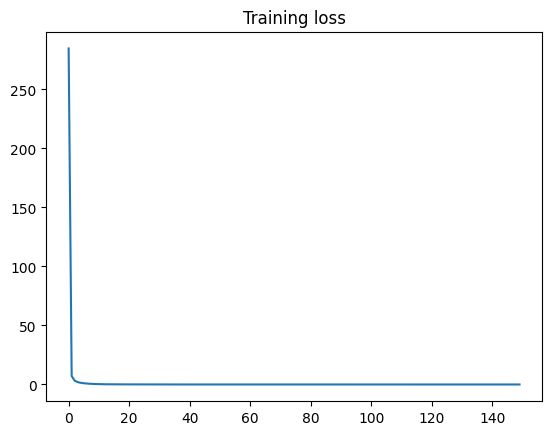

In [15]:
plt.plot(train_loss)
plt.title('Training loss')
plt.show()

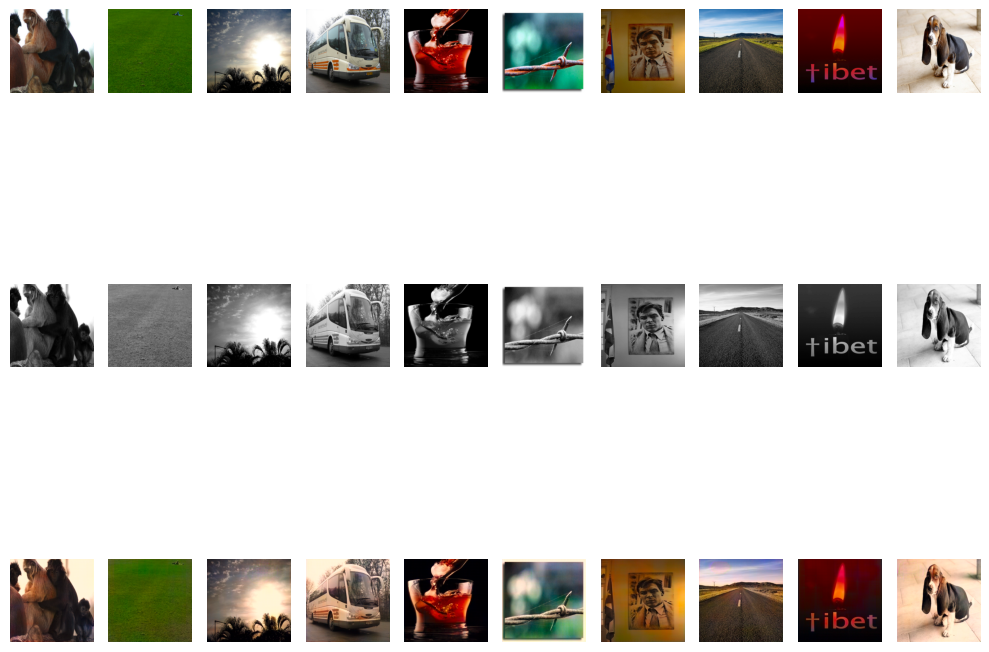

In [17]:
plt.figure(figsize=(10, 10))
for i in range(10):
  plt.subplot(3, 10, i + 1)
  plt.imshow(convert_to_rgb(lab[i], gray[i]))
  plt.axis('off')

  plt.subplot(3, 10, i + 11)
  plt.imshow(gray[i].permute(2, 1, 0).detach().cpu().numpy(), cmap = 'gray')
  plt.axis('off')
  
  plt.subplot(3, 10, i + 21)
  plt.imshow(convert_to_rgb(logits[i], gray[i]))
  plt.axis('off')

plt.tight_layout()
plt.show()

# Test the Model

In [18]:
with torch.no_grad():
  model.eval()
  total_loss = 0
  test_losses = []

  for gray, lab in test_loader:
    logits = model(gray.to(device))
    loss = loss_fn(logits, lab.to(device))
    total_loss += loss.item()
    test_losses.append(total_loss)

print(f'Test loss is {total_loss / len(test_loader)}')

Test loss is 0.004808337660506368


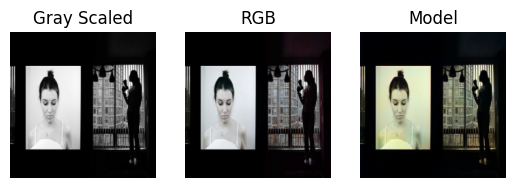

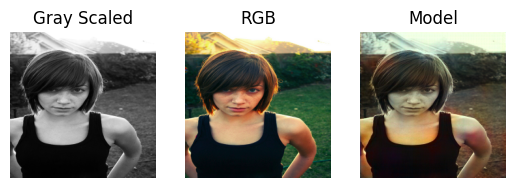

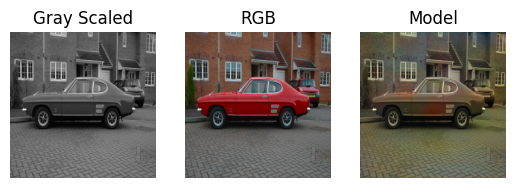

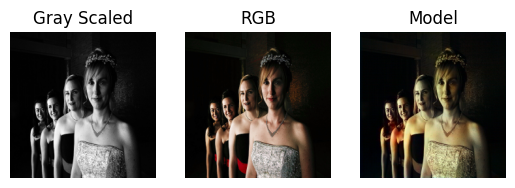

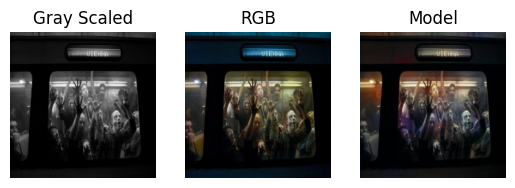

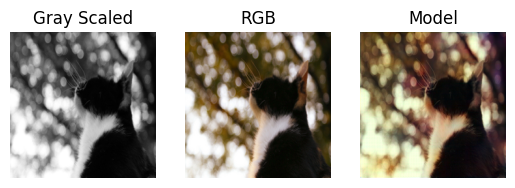

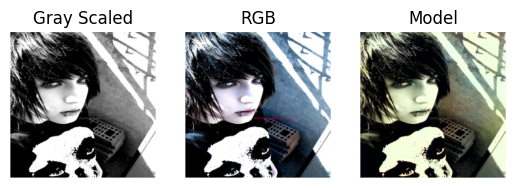

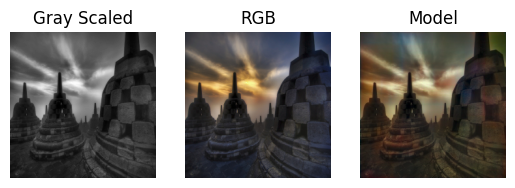

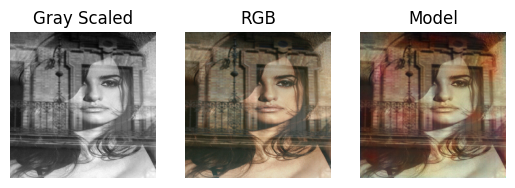

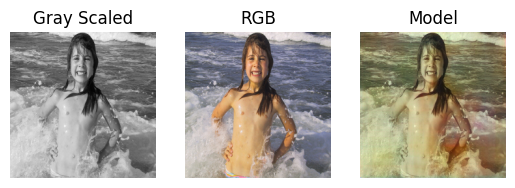

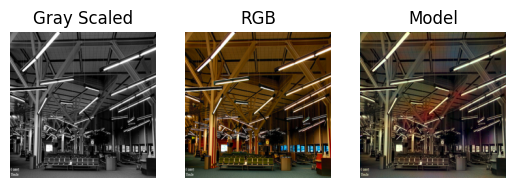

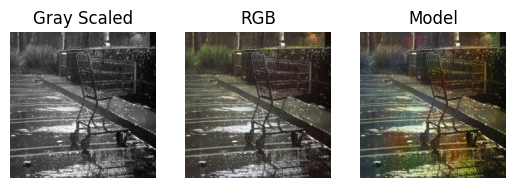

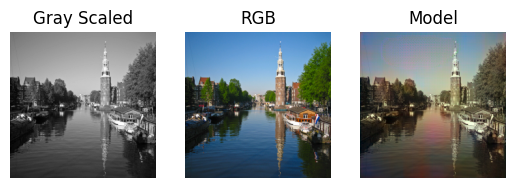

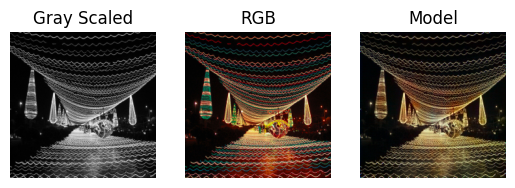

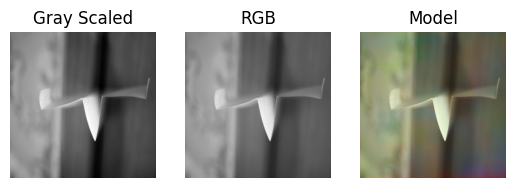

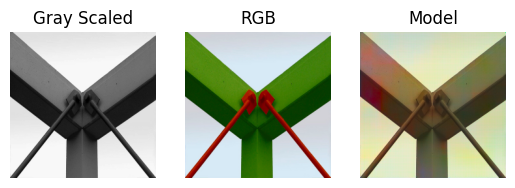

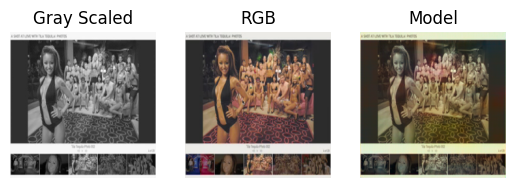

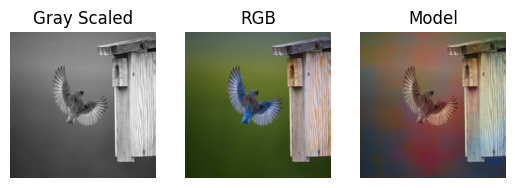

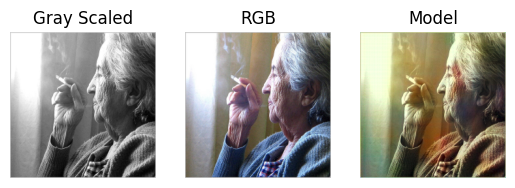

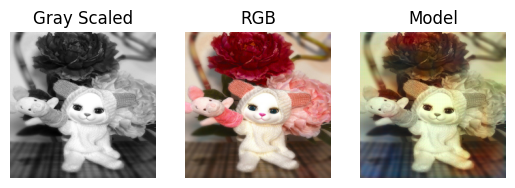

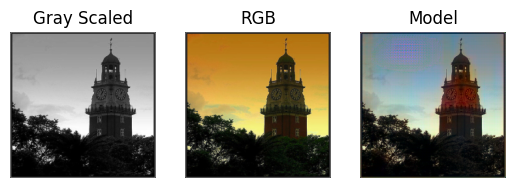

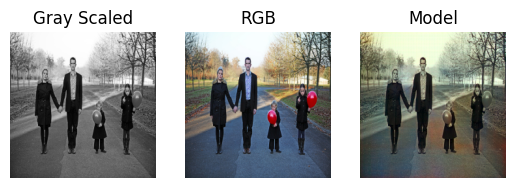

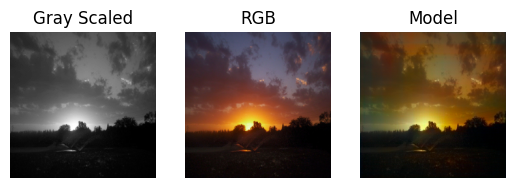

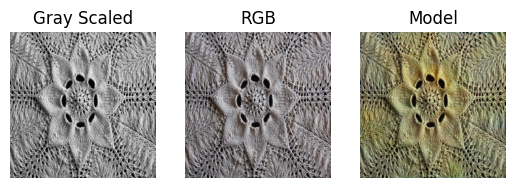

In [25]:
for i in range(logits.shape[0]):
  plt.subplot(1, 3, 1)
  plt.imshow(gray[i].permute(2, 1, 0).detach().cpu().numpy(), cmap = 'gray')
  plt.title('Gray Scaled')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(convert_to_rgb(lab[i], gray[i]))
  plt.title('RGB')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(convert_to_rgb(logits[i], gray[i]))
  plt.title('Model')
  plt.axis('off')

  plt.show()

# Save the Model

In [29]:
torch.save(model.state_dict(), '/kaggle/working/image_colorization.pth')


#### There is a little bit of overfitting to the images, this could be solved by applying some of the regularization technqiues and usage of more data.